# Ridge regression
This is a regression technique wich allows to deal with the multicollinearity of the features and try to reduce the overfitting of the data. 
minimize two elements, the RSS and the objective function 

In ridge regression two elements are optimized , the RSS and the objective function

||y - Xw||^2_2 + alpha * ||w||^2_2 

It is a variation of the Linear regression with a tunning parameter alpha to control model complexity.

## Libraries 

For this analysis, we will use a few libraries for managing and transform the database as well as to implement the ridge regression. First, let's download the libraries 

"$$\n",
    "    r_{i,j} = \\frac{\\sum_{t=1}^m (x_{i,t}-\\mu_i)(x_{j,t}-\\mu_j)}{\\sqrt{\\sum_{t=1}^m (x_{i,t}-\\mu_i)^2}\\sqrt{\\sum_{t=1}^m (x_{j,t}-\\mu_j)^2}}\n",
    "$$\n",
    "where $\\mu_i = (x_{i,1}+\\cdots+x_{i,m})/m$.\n",
    "\n"

In [112]:
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve
from sklearn import decomposition
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

## Data

Open the database, check the structure, show the head, take a look of its structure, the descriptive statistics and manage the columns.
Create the constants 
The target value is the median_house_value which is predicted based on the features of different houses. 

In [207]:
shuffleDataSet = True
RMS = 'neg_mean_squared_error'

column_to_predict = 'median_house_value'
categories_columns = ['ocean_proximity']
numerics_columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]

In [208]:
data_frame = pandas.read_csv(filepath_or_buffer='cal-housing.csv')
data_frame = data_frame.sample(frac=1).reset_index(drop=True)

In [209]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
data_frame.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
data_frame.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-117.88,33.84,26.0,1499.0,290.0,755.0,277.0,3.5893,238500.0,<1H OCEAN
1,-121.47,38.54,36.0,2099.0,510.0,1845.0,483.0,1.4138,52500.0,INLAND
2,-122.13,37.89,27.0,744.0,214.0,295.0,169.0,2.7411,350000.0,NEAR BAY
3,-117.99,34.05,35.0,1792.0,317.0,1441.0,306.0,3.7917,151100.0,<1H OCEAN
4,-119.27,36.05,29.0,1016.0,174.0,481.0,140.0,2.2917,112500.0,INLAND


Here is the distribution of the values of the target variable "median_house_value". 
It looks like a normal distribution with a group of outliers on the hihest value of the house.

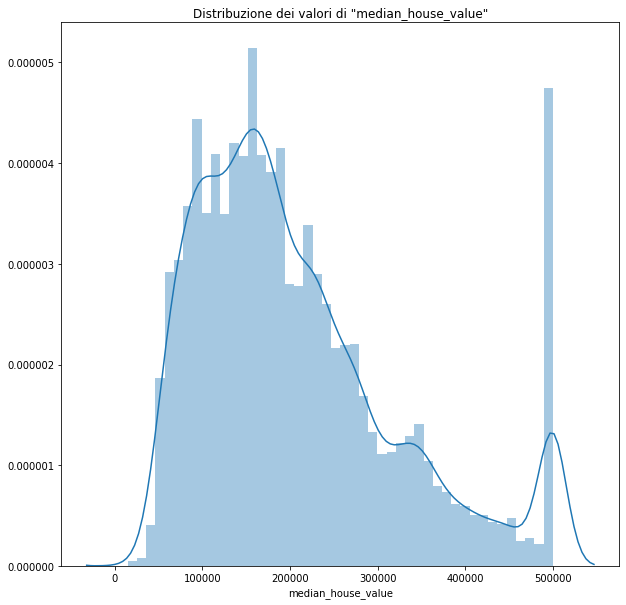

In [7]:
plt.figure(figsize=(10, 10))
plt.title('Distribuzione dei valori di "median_house_value"')
seaborn.distplot(data_frame[column_to_predict])
plt.show()

## Data set optimization
### Missing values

The dataset has missing values that are handeled by replacing the value with the mean of the column. This procedure is necessary to avoid errors in the execution.

In [210]:
for c in data_frame.columns:
    if data_frame[c].hasnans:
        m = data_frame[c].mean()
        data_frame[c].fillna(value=m, inplace=True)


### categorical feature
Categorical values cannot be treated as such for statistical analysis, therefore they must be transormed in numbers.
Generate columns for each element of the categorical feature. 

In [211]:
columns_categories = pandas.DataFrame()

for c in categories_columns:
    column = pandas.get_dummies(data=data_frame[c], prefix=c + '_')
    columns_categories = pandas.concat((columns_categories, column), axis=1)

columns_categories


,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
0,0,0,0,0,1
1,0,1,0,0,0
2,0,0,0,0,1
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
20635,1,0,0,0,0
20636,0,0,0,0,1
20637,0,1,0,0,0
20638,0,0,0,1,0


delete categorical column and add a column for each element of the categorical column

In [212]:
data_frame.drop(columns=categories_columns, inplace=True)
data_frame = pandas.concat([data_frame, columns_categories], axis=1)

### Correlation of the dataset
Explor the Peasrson's coefficient of correlation and build a simmetric correlation matrix between the features.

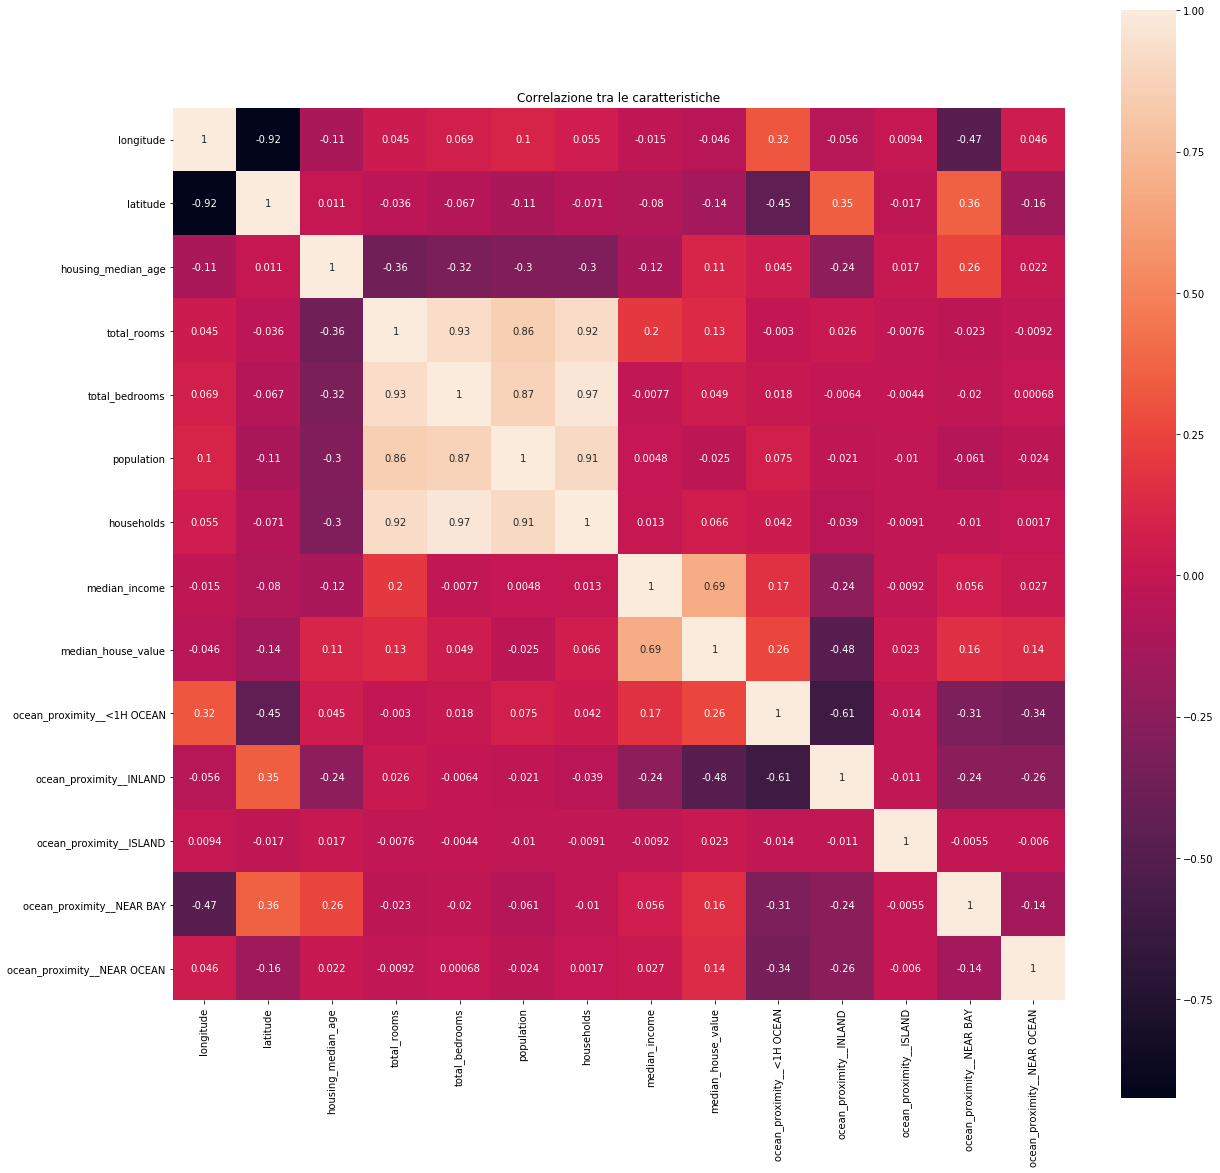

In [213]:
corr = data_frame.corr()
plt.figure(figsize=(20, 20))
plt.title('Correlazione tra le caratteristiche')
seaborn.heatmap(corr, square=True, annot=True)
plt.show()



The coefficient is in between -1 and +1, when it is close to |1| then there is a correlation (positive or negative) otherwise if the coefficient is close to 0 there isn't any correlation. If some features are linearly correlated they are not useful, because we can explain one feature through the correlated one.

In [214]:
correlated_features = corr[((corr > 0.75) | (corr < -0.75)) & (corr != 1.0)].dropna(axis='index', how='all')
correlated_features

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
longitude,NaN,-0.924664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,-0.924664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_rooms,NaN,NaN,NaN,NaN,0.927253,0.857126,0.918484,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_bedrooms,NaN,NaN,NaN,0.927253,NaN,0.873910,0.974725,NaN,NaN,NaN,NaN,NaN,NaN,NaN
population,NaN,NaN,NaN,0.857126,0.873910,NaN,0.907222,NaN,NaN,NaN,NaN,NaN,NaN,NaN
households,NaN,NaN,NaN,0.918484,0.974725,0.907222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Delete the correlated features
1. households che è vincolata a population
2. total_bedrooms che è vincolata a total_rooms

In [228]:
columns_to_remove = ['population', 'total_rooms', 'longitude', column_to_predict]
columns_to_use = list(data_frame.columns)

for u in columns_to_remove:
    columns_to_use.remove(u)
    if numerics_columns.count(u) > 0:
        numerics_columns.remove(u)

X = data_frame.drop(columns=columns_to_remove)
y = data_frame[column_to_predict]

In [229]:
X.head()


,latitude,housing_median_age,total_bedrooms,households,median_income,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
0,37.65,32.0,868.0,817.0,3.5039,0,0,0,0,1
1,36.57,42.0,521.0,483.0,1.5833,0,1,0,0,0
2,32.71,35.0,180.0,164.0,1.6953,0,0,0,0,1
3,33.78,25.0,645.0,646.0,6.5800,1,0,0,0,0
4,34.17,32.0,696.0,621.0,3.4449,1,0,0,0,0


In [230]:
y.head()

0    232400.0
1     65100.0
2     81300.0
3    318500.0
4    292900.0
Name: median_house_value, dtype: float64

## Learning algorithm
### Cross-validated risk estimate

In [179]:
reg = Ridge( alpha = 0.001 )

In [180]:
reg.fit(X,y)
y_pred= reg.predict(X)
y_pred.mean()
numpy.sqrt(mean_squared_error(y, y_pred))

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [231]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.2 , shuffle=shuffleDataSet)

In [232]:
# sostituire con il nostro medoto
alphas = [1, 1e3, 1e6]
learner = RidgeCV(alphas= alphas , store_cv_values = True)
learner.fit(X_train, y_train )
cv_mse = numpy.mean(learner.cv_values_, axis=0 )


In [225]:
print(alphas)

[1, 1000.0, 1000000.0]


In [239]:
print(cv_mse.mean())

8235774169.604844


In [234]:
print(learner.alpha_)

1.0


In [235]:
predict_y = learner.predict(X_test)

In [238]:
print(predict_y)

[296620.73864838 241911.72079893  99030.19295934 ... 195049.97544645
  74375.33139068 119435.89808588]


In [ ]:
scores = cross_val_score(learner, X, y, cv=5, scoring=RMS)
print(f'Cross-validated risk estimate: {-scores.mean()}')

In [184]:
#Hyperparameter optimization with cross-validation
#With the default hyper-parameters: we use the cross-validation score to determine goodness-of-fit:
for Model in [Ridge]:
    model = Model()
    print(Model.__name__, cross_val_score(model, X, y).mean())

Ridge 0.6166709822220359


In [129]:
#chose the best parameter alpha 
for Model in [Ridge]:
    gscv = GridSearchCV(Model(), dict(alpha=alphas), cv=3).fit(X, y)
    print(Model.__name__, gscv.best_params_)

Ridge {'alpha': 0.001}


In [132]:
from sklearn.linear_model import RidgeCV
for Model in [RidgeCV]:
    model = Model(alphas=alphas, cv=3).fit(X, y)
    print(Model.__name__, model.alpha_)

RidgeCV 0.001


In [135]:
for Model in [RidgeCV]:
    scores = cross_val_score(Model(alphas=alphas, cv=3), X, y, cv=3)
    print(Model.__name__, numpy.mean(scores))

RidgeCV 0.6163380693521472


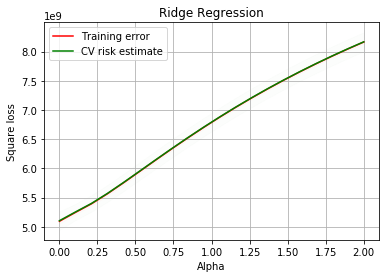

In [146]:
alpha_vals = numpy.linspace(0.001,2.0,20)
train_score, val_score = validation_curve(Ridge(normalize=True), X, y, 'alpha', alpha_vals, cv=5, scoring=RMS)

shuffleDataSet = True
plt.title('Ridge Regression')
train_score_mean = -numpy.mean(train_score, axis=1)
train_score_std = numpy.std(train_score, axis=1)
val_score_mean = -numpy.mean(val_score, axis=1)
val_score_std = numpy.std(val_score, axis=1)
plt.grid()
plt.fill_between(alpha_vals, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha= 0.01,
                 color="r")
plt.fill_between(alpha_vals, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha= 0.01, color="g")
plt.plot(alpha_vals, train_score_mean, color="r",
         label="Training error")
plt.plot(alpha_vals, val_score_mean, color="g",
         label="CV risk estimate")
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Square loss')
plt.show()

Text(0, 0.5, 'weights')

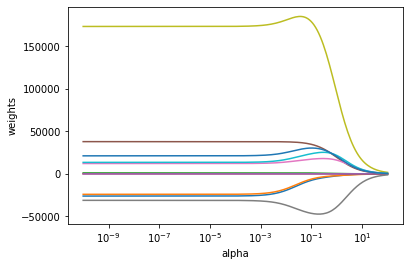

In [151]:
#create a ranage of alphas 
alpha_vals = 10**numpy.linspace(10,-2,100)*0.5
alpha_vals
#we take values of alfa and stipiamo in a list. 
#then :  As with other linear models, Ridge will take 
#in its fit method arrays X, y and will store the coefficients of the linear model in its coef_ member:




ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)     ## fit the  parameter to the data 
    coefs.append(ridge.coef_)  
    
numpy.shape(coefs)

#We expect the coefficient estimates to be much smaller, in terms of l2 norm, when a large value of alpha is used, 
#as compared to when a small value of alpha is used. Let's plot and find out:
#As expected, increasing λ drives the parameters towards 0. In a real-world example, those parameters that approach zero slower 
#than others might correspond to the more informative features. 
#It is in this sense that ridge regression can be considered model selection.

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')


(100, 11)

In [ ]:
#youtube guy marco 
ridge=Ridge()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(X,y)


In [66]:
ridge.score(X, y)

0.6170813773112297

In [70]:
print(ridge_regressor.best_params_)
print(-ridge_regressor.best_score_)

{'alpha': 1}
5100682505.399897


Automatically created module for IPython interactive environment


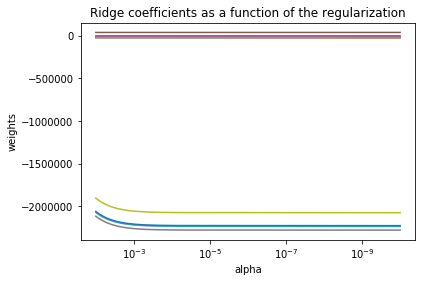

In [144]:
print(__doc__)

import numpy 
import matplotlib.pyplot as plt
from sklearn import linear_model



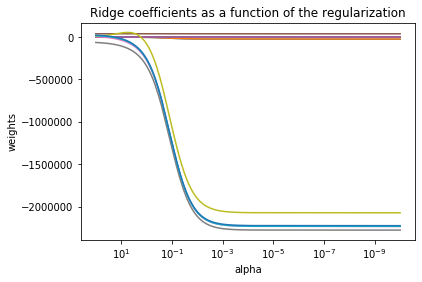

In [145]:
n_alphas = 200
alphas = numpy.logspace(-10, 2, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

# #############################################################################
# Display results

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

Text(0, 0.5, 'weights')

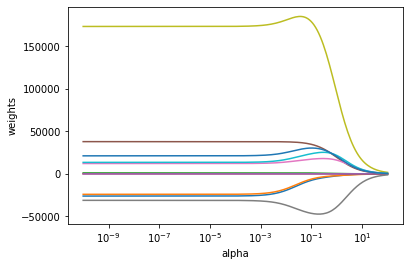

In [42]:
# Split data into training and test sets
#We now split the samples into a training set and a test set
#in order to estimate the test error of ridge regression 
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [43]:
ridge2 = Ridge(alpha = 4, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pandas.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2))          # Calculate the test MSE

longitude                       -842.304621
latitude                       -1068.612370
housing_median_age               193.437716
total_bedrooms                     2.341560
households                         3.162685
median_income                   8053.449721
ocean_proximity__<1H OCEAN      8845.607123
ocean_proximity__INLAND       -20048.160504
ocean_proximity__ISLAND        34748.316465
ocean_proximity__NEAR BAY      11180.024445
ocean_proximity__NEAR OCEAN     8829.582768
dtype: float64
9704830309.27217


In [46]:
ridge3 = Ridge(alpha = 0.5, normalize = True)
ridge3.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred3 = ridge3.predict(X_test)           # Use this model to predict the test data
print(pandas.Series(ridge3.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred3))          # Calculate the test MSE

longitude                       -3456.848328
latitude                        -2735.398725
housing_median_age                657.838059
total_bedrooms                      8.811167
households                          7.776761
median_income                   25611.268861
ocean_proximity__<1H OCEAN      17204.120774
ocean_proximity__INLAND        -44831.030115
ocean_proximity__ISLAND        125633.223080
ocean_proximity__NEAR BAY       25853.242618
ocean_proximity__NEAR OCEAN     24471.385119
dtype: float64
5900052570.299261


### Learning curve 

In [1095]:
# records da 1 a 2851, step 550 = 7 punti
sizes = range(1, 3851, 550)

# 5 fold di C.V.
train_size, train_score, val_score = learning_curve(learner, X, y, train_sizes=sizes, cv=5, scoring=RMS)

### Standard deviation
Standard deviation is the most important tool for dispersion measurement in a distribution. Technically, the standard deviation is the square root of the arithmetic mean of the squares of deviations of observations from their mean value.
### Arithmetic Mean
Mean is the measure of central tendency most commonly used. Mean is equal to the sum of all the values of a collection of data divided by the number of values in the data.

In [1096]:
train_score_mean = -numpy.mean(train_score, axis=1)
train_score_std = numpy.std(train_score, axis=1)
val_score_mean = -numpy.mean(val_score, axis=1)
val_score_std = numpy.std(val_score, axis=1)

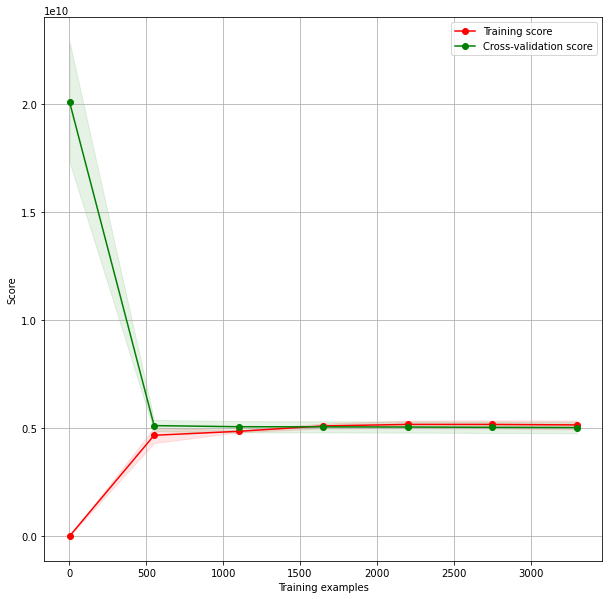

In [1097]:
plt.figure(figsize=(10, 10))
plt.grid()

plt.fill_between(sizes, train_score_mean - train_score_std, train_score_mean + train_score_std, color="r", alpha=0.1)
plt.fill_between(sizes, val_score_mean - val_score_std, val_score_mean + val_score_std, color="g", alpha=0.1)

plt.plot(sizes, train_score_mean, 'o-', color="r", label="Training score")
plt.plot(sizes, val_score_mean, 'o-', color="g", label="Cross-validation score")

plt.legend()
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.show()

## Principal Component Analysis
To increase the stability of the regression, the PCA is a method used to reduce number of variables in your data by extracting important one from a large pool. It reduces the dimension of your data with the aim of retaining as much information as possible. In other words, this method combines highly correlated variables together to form a smaller number of an artificial set of variables which is called “principal components” that account for most variance in the data. 

In [1098]:
coef_list = []

for s in sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=s, shuffle=shuffleDataSet)
    learner.fit(X_train, y_train)
    coef_list.append(learner.coef_)

coef_matrix = numpy.array(coef_list)

pca = decomposition.PCA(n_components=2)
pca.fit(coef_matrix)
coef_pca = pca.transform(coef_matrix)

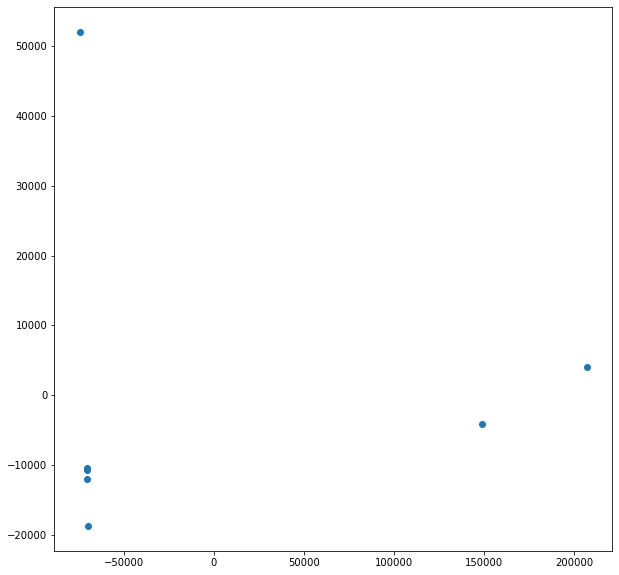

In [1099]:
plt.figure(figsize=(10, 10))
plt.scatter(coef_pca[:, 0], coef_pca[:, 1])


In [1100]:
pca = decomposition.PCA(n_components=X.shape[1])
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=11, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

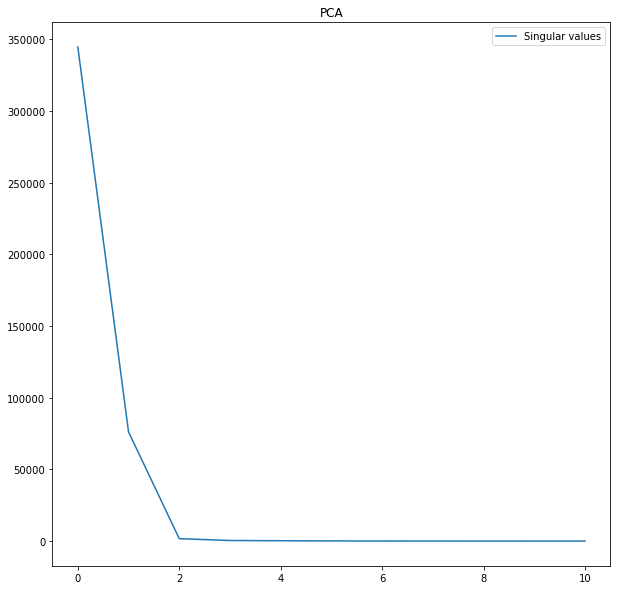

In [1101]:
plt.figure(figsize=(10, 10))
plt.title('PCA')
plt.plot(pca.singular_values_, label='Singular values')
plt.legend()
plt.show()

We project all the datapoints on the principal components. Then we check the learning curve again.

In [1102]:
pca = decomposition.PCA(n_components=4)
pca.fit(X)
X_pca = pca.transform(X)

In [1103]:
X

,longitude,latitude,housing_median_age,total_rooms,population,median_income,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
0,-121.75,36.76,32.0,1740.0,1563.0,2.7694,1,0,0,0,0
1,-119.14,34.49,17.0,321.0,92.0,7.7500,1,0,0,0,0
2,-117.04,32.68,14.0,1320.0,943.0,5.0947,0,0,0,0,1
3,-117.11,32.74,33.0,1126.0,621.0,3.2422,0,0,0,0,1
4,-116.62,34.23,14.0,6438.0,1586.0,1.6136,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
20635,-118.26,33.97,44.0,1246.0,1031.0,1.9556,1,0,0,0,0
20636,-116.45,33.78,16.0,5228.0,1177.0,3.0859,0,1,0,0,0
20637,-122.03,37.56,24.0,8444.0,4446.0,4.6978,0,0,0,1,0
20638,-118.37,33.97,41.0,1833.0,847.0,5.7260,1,0,0,0,0


In [1104]:
X_pca.shape

(20640, 4)

In [1105]:
X_pca

array([[-7.51010284e+02,  5.07244745e+02,  1.24132669e+00,
         2.57417614e+00],
       [-2.66261025e+03, -2.16017182e+02, -1.63262756e+01,
        -1.61397838e+00],
       [-1.39570174e+03,  1.26262447e+02, -1.74925315e+01,
        -3.74760280e+00],
       ...,
       [ 6.54199991e+03,  2.47749483e+02,  7.27954581e+00,
         3.61477643e+00],
       [-9.73025501e+02, -1.79779379e+02,  1.07744285e+01,
        -2.55406780e+00],
       [ 7.67929165e+02, -2.78482162e+02, -1.48170483e+01,
        -1.81915625e+00]])

In [1106]:
# 5 fold di C.V.
train_size, train_score, val_score = learning_curve(learner, X_pca, y, train_sizes=sizes, cv=5, scoring=RMS)

In [1107]:
train_score_mean = -numpy.mean(train_score, axis=1)
train_score_std = numpy.std(train_score, axis=1)
val_score_mean = -numpy.mean(val_score, axis=1)
val_score_std = numpy.std(val_score, axis=1)

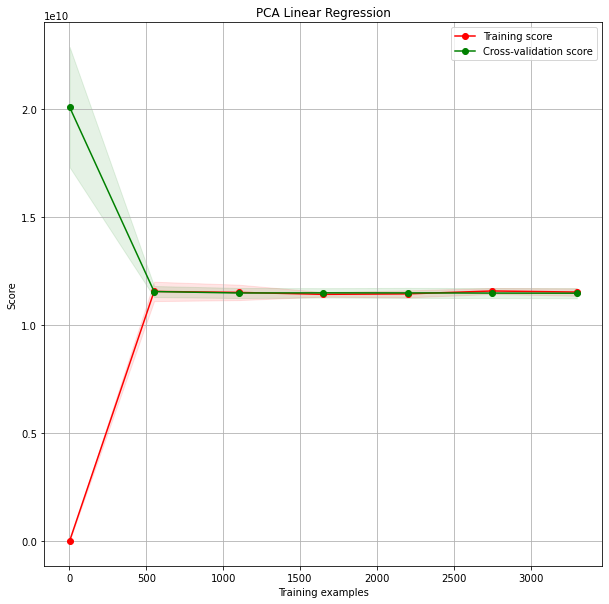

In [1108]:
plt.figure(figsize=(10, 10))
plt.title('PCA Linear Regression')
plt.grid()

plt.fill_between(sizes, train_score_mean - train_score_std, train_score_mean + train_score_std, color="r", alpha=0.1)
plt.fill_between(sizes, val_score_mean - val_score_std, val_score_mean + val_score_std, color="g", alpha=0.1)

plt.plot(sizes, train_score_mean, 'o-', color="r", label="Training score")
plt.plot(sizes, val_score_mean, 'o-', color="g", label="Cross-validation score")

plt.legend()
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.show()

In [1109]:
coef_list = []

for s in sizes:
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, train_size=s, shuffle=shuffleDataSet)
    learner.fit(X_train, y_train)
    coef_list.append(learner.coef_)

coef_matrix = numpy.array(coef_list)

In [1110]:
pca = decomposition.PCA(n_components=2)
pca.fit(coef_matrix)
coef_pca = pca.transform(coef_matrix)

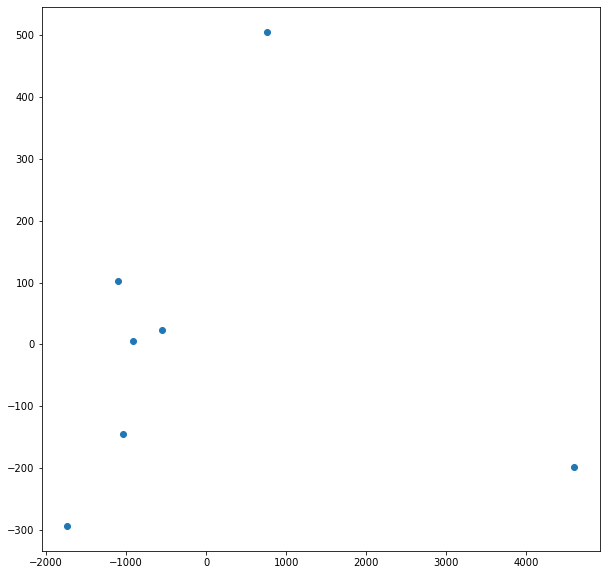

In [1111]:
plt.figure(figsize=(10, 10))
plt.scatter(coef_pca[:,0], coef_pca[:,1])
plt.show()

##  Ridge Regression

In [1112]:
alpha_vals = numpy.linspace(0.01, 2.0, 20)
train_score, val_score = validation_curve(Ridge(alpha=0.01, normalize=True), X, y, 'alpha', alpha_vals, cv=5, scoring=RMS)

In [1113]:
train_score_mean = -numpy.mean(train_score, axis=1)
train_score_std = numpy.std(train_score, axis=1)
val_score_mean = -numpy.mean(val_score, axis=1)
val_score_std = numpy.std(val_score, axis=1)

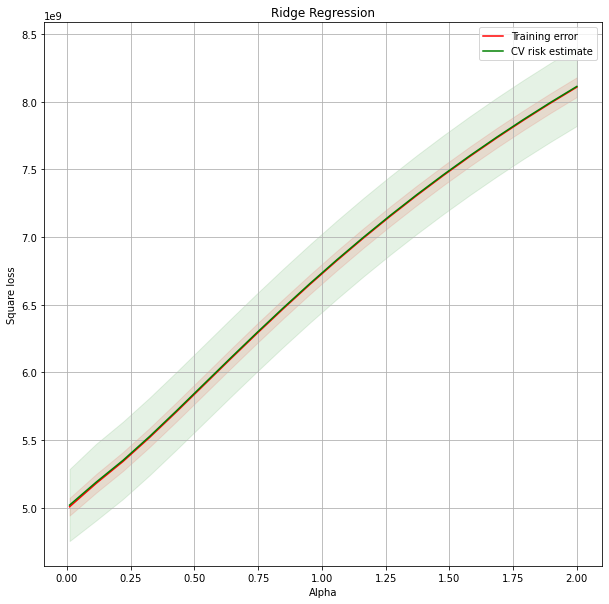

In [1114]:
plt.figure(figsize=(10, 10))
plt.title('Ridge Regression')
plt.grid()

plt.fill_between(alpha_vals, train_score_mean - train_score_std, train_score_mean + train_score_std, alpha=0.1, color="r")
plt.fill_between(alpha_vals, val_score_mean - val_score_std, val_score_mean + val_score_std, alpha=0.1, color="g")

plt.plot(alpha_vals, train_score_mean, color="r", label="Training error")
plt.plot(alpha_vals, val_score_mean, color="g", label="CV risk estimate")

plt.xlabel('Alpha')
plt.ylabel('Square loss')
plt.legend()
plt.show()

In [1115]:
l_train_size, l_train_score, l_val_score = learning_curve(LinearRegression(normalize=True), X_pca, y, train_sizes=sizes, cv=5, scoring=RMS)
r_train_size, r_train_score, r_val_score = learning_curve(Ridge(alpha=0.01, normalize=True), X_pca, y, train_sizes=sizes, cv=5, scoring=RMS)

In [1116]:
l_val_score_mean = -numpy.mean(l_val_score, axis=1)
l_val_score_std = numpy.std(l_val_score, axis=1)
r_val_score_mean = -numpy.mean(r_val_score, axis=1)
r_val_score_std = numpy.std(r_val_score, axis=1)

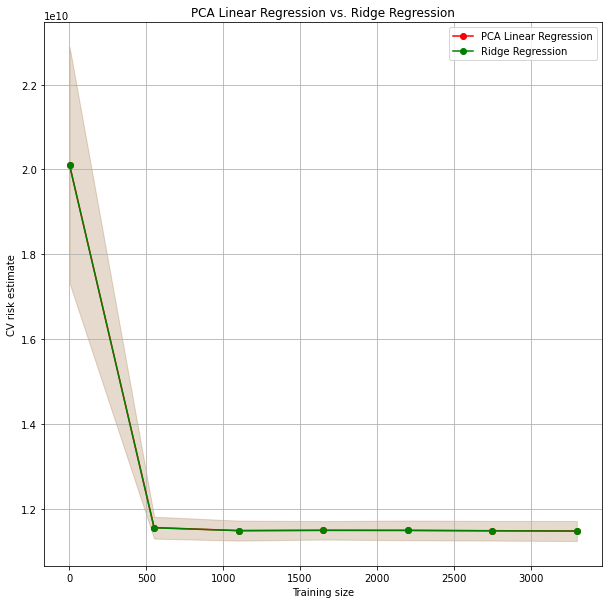

In [1117]:
plt.figure(figsize=(10, 10))
plt.title('PCA Linear Regression vs. Ridge Regression')
plt.grid()

plt.fill_between(sizes, l_val_score_mean - l_val_score_std, l_val_score_mean + l_val_score_std, alpha=0.1, color="r")
plt.fill_between(sizes, r_val_score_mean - r_val_score_std, r_val_score_mean + r_val_score_std, alpha=0.1, color="g")

plt.plot(sizes, l_val_score_mean, 'o-', color="r", label="PCA Linear Regression")
plt.plot(sizes, r_val_score_mean, 'o-', color="g", label="Ridge Regression")

plt.xlabel('Training size')
plt.ylabel('CV risk estimate')
plt.legend()
plt.show()